<a href="https://colab.research.google.com/github/joshsbloom/swabseq/blob/master/kb/notebooks/comparison_v18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/joshsbloom/swabseq.git

Cloning into 'swabseq'...
remote: Enumerating objects: 238, done.
remote: Counting objects: 100% (238/238), done.
remote: Compressing objects: 100% (194/194), done.
remote: Total 935 (delta 99), reused 155 (delta 44), pack-reused 697
Receiving objects: 100% (935/935), 33.07 MiB | 11.38 MiB/s, done.
Resolving deltas: 100% (427/427), done.


In [2]:
!wget http://131.215.54.5:8080/media/core/2/matrix.h5ad

--2020-07-27 23:30:10--  http://131.215.54.5:8080/media/core/2/matrix.h5ad
Connecting to 131.215.54.5:8080... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13926293 (13M) [application/octet-stream]
Saving to: ‘matrix.h5ad’

matrix.h5ad         100%[===================>]  13.28M  9.23MB/s    in 1.4s    

2020-07-27 23:30:12 (9.23 MB/s) - ‘matrix.h5ad’ saved [13926293/13926293]



In [3]:
!wget http://131.215.54.5:8080/media/core/2/samplesheet.csv

--2020-07-27 23:30:22--  http://131.215.54.5:8080/media/core/2/samplesheet.csv
Connecting to 131.215.54.5:8080... connected.
HTTP request sent, awaiting response... 200 OK
Length: 189755 (185K) [application/octet-stream]
Saving to: ‘samplesheet.csv’

samplesheet.csv     100%[===================>] 185.31K   483KB/s    in 0.4s    

2020-07-27 23:30:23 (483 KB/s) - ‘samplesheet.csv’ saved [189755/189755]



# Install packages

In [4]:
!pip install anndata

     |████████████████████████████████| 122kB 2.8MB/s 


In [5]:
# Convert samplesheet to csv for loading
def samplesheet_to_csv(samplesheet, csv):
    with open(samplesheet, 'r') as ss, open(csv,'w') as c:
        line = ss.readline().strip()
        while line != '[Data]':
            line = ss.readline().strip()

        # the rest of the lines are data
        for line in ss:
          c.write(line)
samplesheet_to_csv("samplesheet.csv", "ss.csv")

In [6]:
!head ss.csv

Plate_ID,virus_identity,lysate,virus_copy,bc_set,Plate_384,Plate_384_quadrant,MasterMixVol,RT,SpikeCopies,RPP_strategy,Sample_Well,Sample_ID,index,index2
Plate9,NBC,NP swab into VTM,Negative Patient,N1_S2_RPP30,3,1,20uL,taqpath,500,50,A01,Plate9-A01-1,GTGAGTCTGT,TCATGGTGGT
Plate9,NBC,NP swab into VTM,Negative Patient,N1_S2_RPP30,3,1,20uL,taqpath,500,50,A01,Plate9-A01-2,TCACCGCAAC,GATCCGACAG
Plate9,N5337,NP swab into VTM,Negative Patient,N1_S2_RPP30,3,1,20uL,taqpath,500,50,A02,Plate9-A02-1,CAGCATTGCA,CTTAGTCAGG
Plate9,N5337,NP swab into VTM,Negative Patient,N1_S2_RPP30,3,1,20uL,taqpath,500,50,A02,Plate9-A02-2,TATGACAGCC,CGTCCTTGTT
Plate9,N5345,NP swab into VTM,Negative Patient,N1_S2_RPP30,3,1,20uL,taqpath,500,50,A03,Plate9-A03-1,GTTACATCGG,CGATTCCTCG
Plate9,N5345,NP swab into VTM,Negative Patient,N1_S2_RPP30,3,1,20uL,taqpath,500,50,A03,Plate9-A03-2,ATGTTCTCAG,TCACCGATGG
Plate9,N5353,NP swab into VTM,Negative Patient,N1_S2_RPP30,3,1,20uL,taqpath,500,50,A04,Plate9-A04-1,AACGTGACGC,ATGTTCT

# Python analysis

In [7]:
#@title Imports
import anndata
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec


def nd(arr):
  return np.asarray(arr).reshape(-1)

def yex(ax, offset=0):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    # now plot both limits against eachother
    ax.plot(lims, np.array(lims)+offset, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

#  Load data

In [8]:
adata = anndata.read_h5ad("matrix.h5ad")
adata.obs['index'] = adata.obs.index.str.slice(0, 10)
adata.obs['index2'] = adata.obs.index.str.slice(10)

In [147]:
ss = pd.read_csv('ss.csv')
ss['bcs'] = ss['index'] + ss['index2']
ss.index = ss['bcs']
ss["sample_id"] = ss["Plate_ID"] + "_" + ss["Sample_Well"]
print(ss.bcs.nunique())
samples = ss['Sample_ID'].values
index = ss['index'].values
index2 = ss['index2'].values

1536


# Collapse the Rpp30 and S and S spike

In [10]:
data = adata[adata.obs.index.isin(ss.bcs.values)]
data = data[data.obs.sort_values("Sample_ID").index]
data.obs["sample_id"] = data.obs.Plate_ID.astype(str) + "_" + data.obs.Sample_Well.astype(str)

In [88]:
bcs_lst = data.obs.bcs.values.astype(str)
sample_id_lst = data.obs.sample_id.values.astype(str)

In [91]:
mtx = []
data.obs.groupby(["Plate_ID", "Sample_Well"]).apply(lambda x: mtx.append(nd(data.X[np.squeeze([np.where(bcs_lst == i)[0] for i in x.index.values] ) ].sum(axis=0))))
mtx = np.squeeze(mtx).astype(int)

In [92]:
mtx.astype(int)

array([[   14,  5642,     0,     0,     1],
       [   57, 22441,     0,     0,  1088],
       [   26,  5351,     0,     0,  3232],
       ...,
       [   18, 12558,     0,     0,  2485],
       [   12,  7997,     0,     0,  3463],
       [   12,  7002,     0,     0,  3017]])

In [93]:
mtx.shape

(767, 5)

In [94]:
data.X.todense().astype(int)

matrix([[   14,  5642,     0,     0,     1],
        [   56, 22441,     0,     0,     1],
        [    1,     0,     0,     0,  1087],
        ...,
        [    0,     0,     0,     0,  3462],
        [   12,  7002,     0,     0,     0],
        [    0,     0,     0,     0,  3017]])

In [101]:
obs = data.obs.drop_duplicates("sample_id")
var = data.var
ndata = anndata.AnnData(X=mtx, obs=obs, var=var)

In [102]:
ndata.obs['sample_id'] = ndata.obs.Plate_ID.astype(str) + "_" + ndata.obs.Sample_Well.astype(str)

# Load simple

In [103]:
def make_mtx(bcs, ecs, cnt, unique_ecs):
    
    bold = bcs[0]
    eold = ecs[0]
    cold = cnt[0]
    mtx = []
    
    d = defaultdict()
    #d[eold] = cold
    bold = 0
    for idx, b in enumerate(bcs):
    
        if b != bold and idx > 0:
            count = []
            for e in unique_ecs:
    
                count.append(d.get(e, 0))
            
            mtx.append(count)
            d = defaultdict()
    
        d[ecs[idx]] = cnt[idx]
    
        bold = b
    count = []
    for e in unique_ecs:
        count.append(d.get(e, 0))
    mtx.append(count)
    
    return np.asarray(mtx)

In [104]:
simple = pd.read_csv("swabseq/runs/v18/countTable.csv")
simple["sample_id"] = simple.Plate_ID + "_" + simple.Sample_Well

In [105]:
var = simple.amplicon.unique()
obs = simple.mergedIndex.unique()

In [106]:
df = simple.groupby(["sample_id","amplicon"])["Count"].sum().reset_index()

In [107]:
bcs = df.sample_id
var = df.amplicon
cnt = df.Count

unique_var = np.unique(var)

mtx = make_mtx(bcs, var, cnt, unique_var)

sm = anndata.AnnData(X=mtx.astype(int), obs = {"sample_id": df.drop_duplicates("sample_id").sample_id.values}, var = {"amplicon": unique_var})

In [108]:
sm.X = sm.X.astype(int)

# Do the actual comparison

In [109]:
gene_map = {
    "S2": "S2",
    "S2_spikein": "S2_spike",
    "RPP30": "RPP30"
}

In [110]:
m = [True, True, False, False, True]
kb = ndata[:,m].copy()

In [111]:
kb.var.index = kb.var.index.map(gene_map).values

In [112]:
kb.var

""
S2
S2_spike
RPP30


In [113]:
kb_bcs = kb.obs.sample_id.values
sm_bcs = sm.obs.sample_id.values

common = np.intersect1d(kb_bcs, sm_bcs)

In [114]:
common.shape

(767,)

In [115]:
kb = kb[kb.obs.sample_id.isin(common).values]
sm = sm[sm.obs.sample_id.isin(common).values]

In [116]:
sm = sm[sm.obs.sort_values("sample_id").index]
sm = sm[:,sm.var.sort_index().index]

kb = kb[kb.obs.sort_values("sample_id").index]
kb = kb[:,kb.var.sort_index().index]

In [117]:
g = ["RPP30",
"S2",
"S2_spike"]

In [118]:
def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

import matplotlib as mpl
from scipy import stats

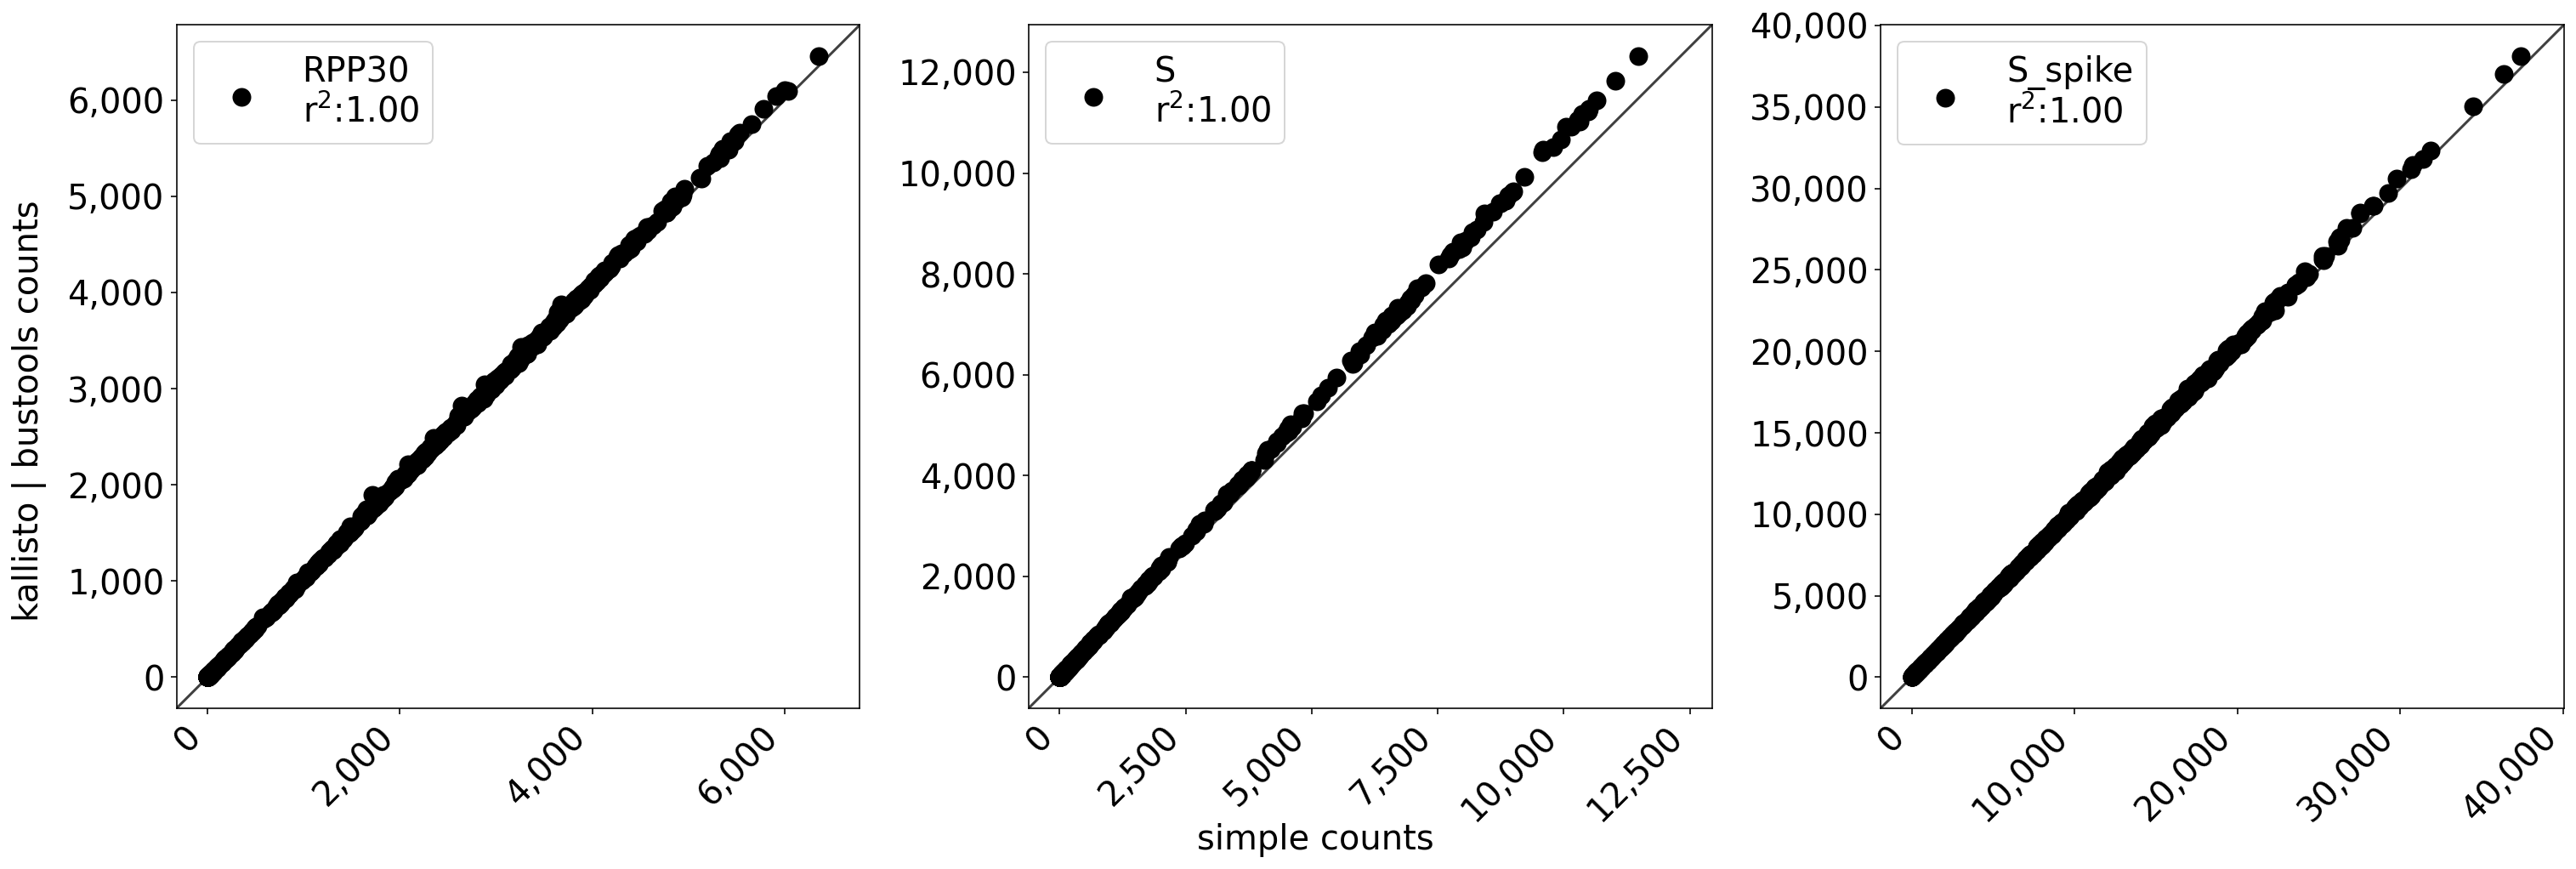

In [119]:
fig, ax = plt.subplots(figsize=(7*3,7), ncols=3)
axs = trim_axs(ax, len(kb.var.index.values))


for gidx, (ax, gene) in enumerate(zip(axs, g)):
    kb_gidx = np.where(kb.var.index.values==gene)[0][0]
    sm_gidx = np.where(sm.var.amplicon.values==gene)[0][0]
    x = nd(sm.X[:,sm_gidx])
    y = nd(kb.X[:,kb_gidx])
    #c = (y>250000).astype(int)
    
    r, p = stats.pearsonr(x, y)
    
    if gene=="S2":
        gene = "S"
    elif gene == "S2_spike":
        gene="S_spike"
    
    ax.scatter(x, y, color="k", s=100,  label="{}\nr$^2$:{:,.2f}".format(gene, r**2))
    
    yex(ax)
    #ax.set_axis_off()
    ax.legend(loc="upper left")

    ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    
    for label in ax.get_xticklabels():
        label.set_ha("right")
        label.set_rotation(45)
fig.text(0.5, 0, 'simple counts', ha='center', va='center', fontsize=20)
fig.text(0, 0.5, 'kallisto | bustools counts', ha='center', va='center', rotation='vertical', fontsize=20)

plt.tight_layout()
#plt.savefig("./figs/kb_v_starcode.png",bbox_inches='tight', dpi=300)
plt.show()

In [149]:
ntc = ss.query("virus_copy=='0.0'")["sample_id"]


In [150]:
ntc.shape

(92,)

In [151]:
kb_ntc = kb[kb.obs.sample_id.isin(ntc).values].copy()
sm_ntc = sm[sm.obs.sample_id.isin(ntc).values].copy()

In [153]:
kb_ntc.shape, sm_ntc.shape

((46, 3), (46, 3))

# Counts for NTC

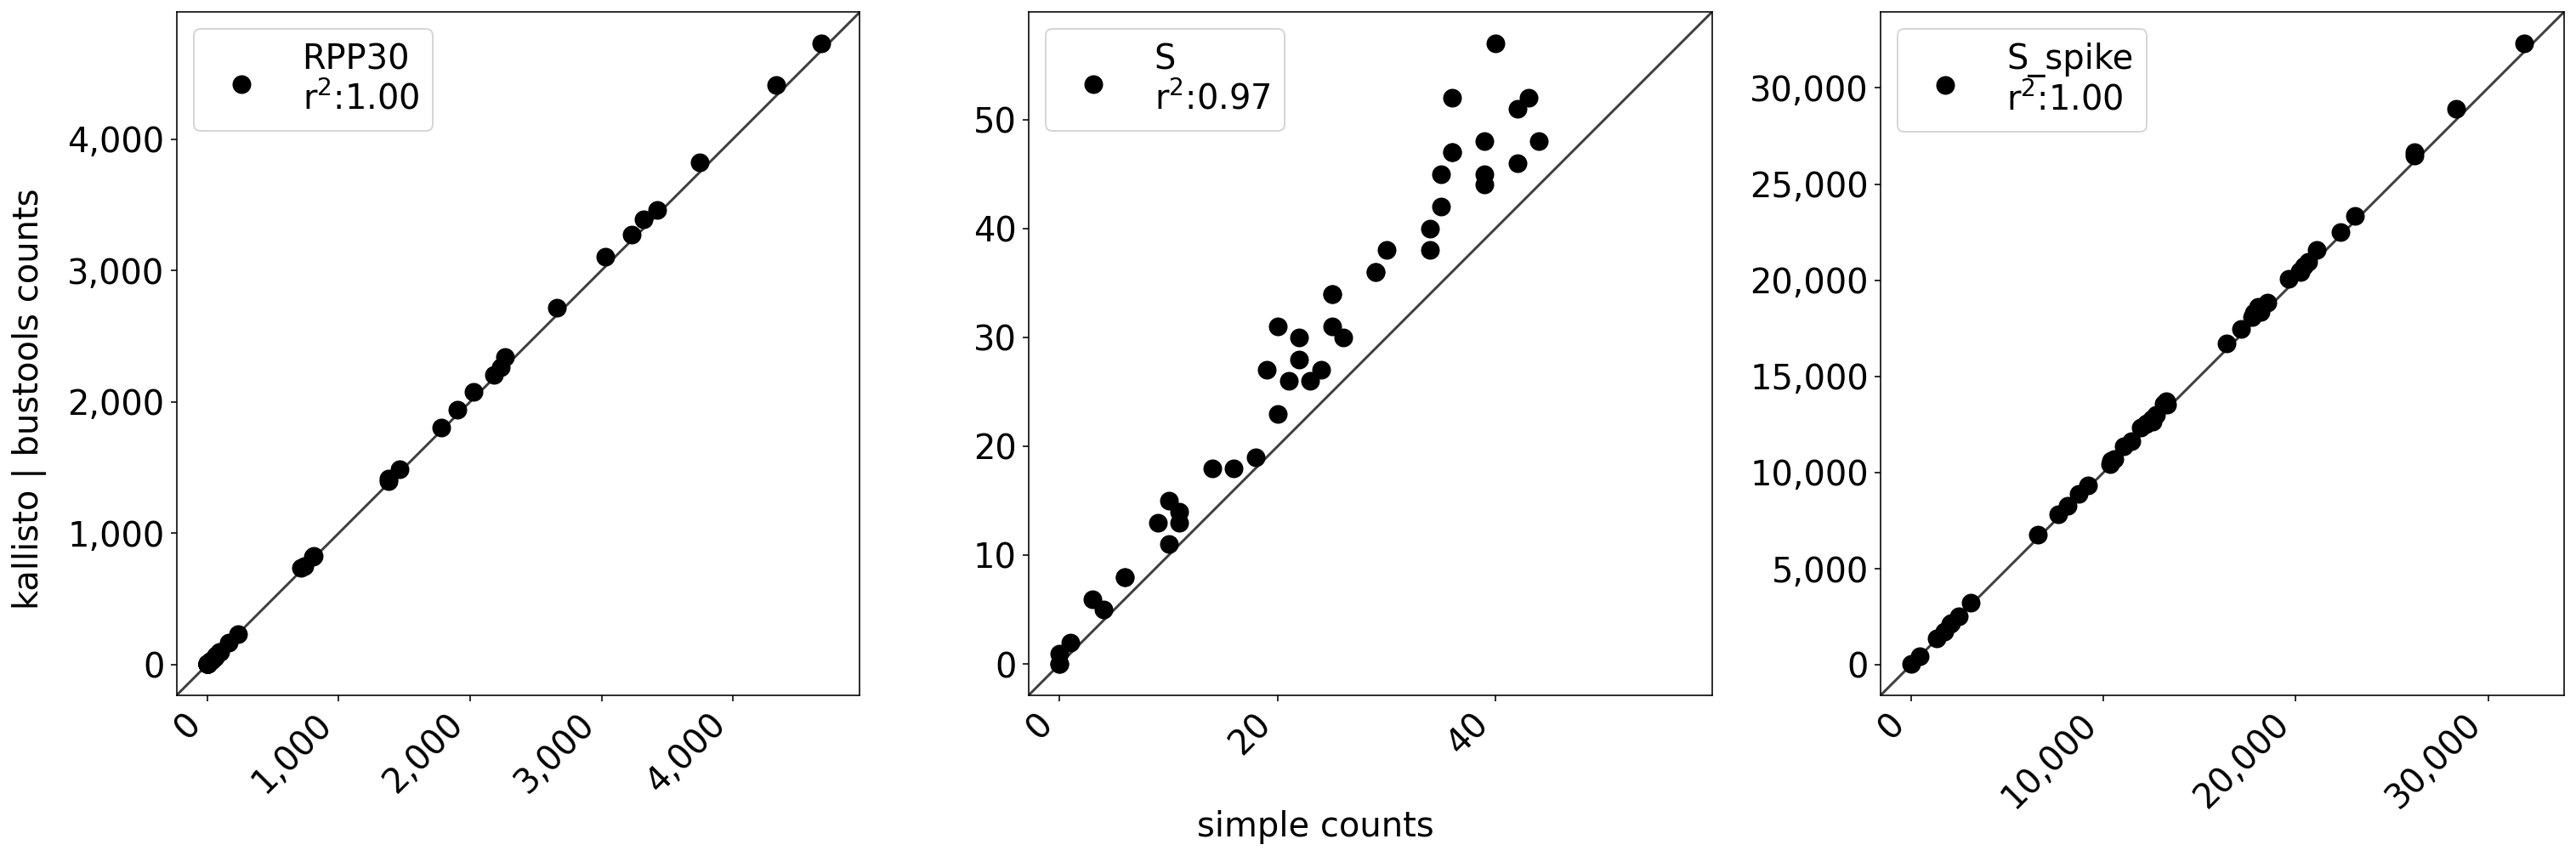

In [154]:
fig, ax = plt.subplots(figsize=(7*3,7), ncols=3)
axs = trim_axs(ax, len(kb_ntc.var.index.values))


for gidx, (ax, gene) in enumerate(zip(axs, g)):
    kb_gidx = np.where(kb_ntc.var.index.values==gene)[0][0]
    sm_gidx = np.where(sm_ntc.var.amplicon.values==gene)[0][0]
    x = nd(sm_ntc.X[:,sm_gidx])
    y = nd(kb_ntc.X[:,kb_gidx])
    #c = (y>250000).astype(int)
    
    r, p = stats.pearsonr(x, y)
    
    if gene=="S2":
        gene = "S"
    elif gene == "S2_spike":
        gene="S_spike"
    
    ax.scatter(x, y, color="k", s=100,  label="{}\nr$^2$:{:,.2f}".format(gene, r**2))
    
    yex(ax)
    #ax.set_axis_off()
    ax.legend()

    ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    
    for label in ax.get_xticklabels():
        label.set_ha("right")
        label.set_rotation(45)
fig.text(0.5, 0, 'simple counts', ha='center', va='center', fontsize=20)
fig.text(0, 0.5, 'kallisto | bustools counts', ha='center', va='center', rotation='vertical', fontsize=20)

plt.tight_layout()
#plt.savefig("./figs/kb_v_starcode.png",bbox_inches='tight', dpi=300)
plt.show()

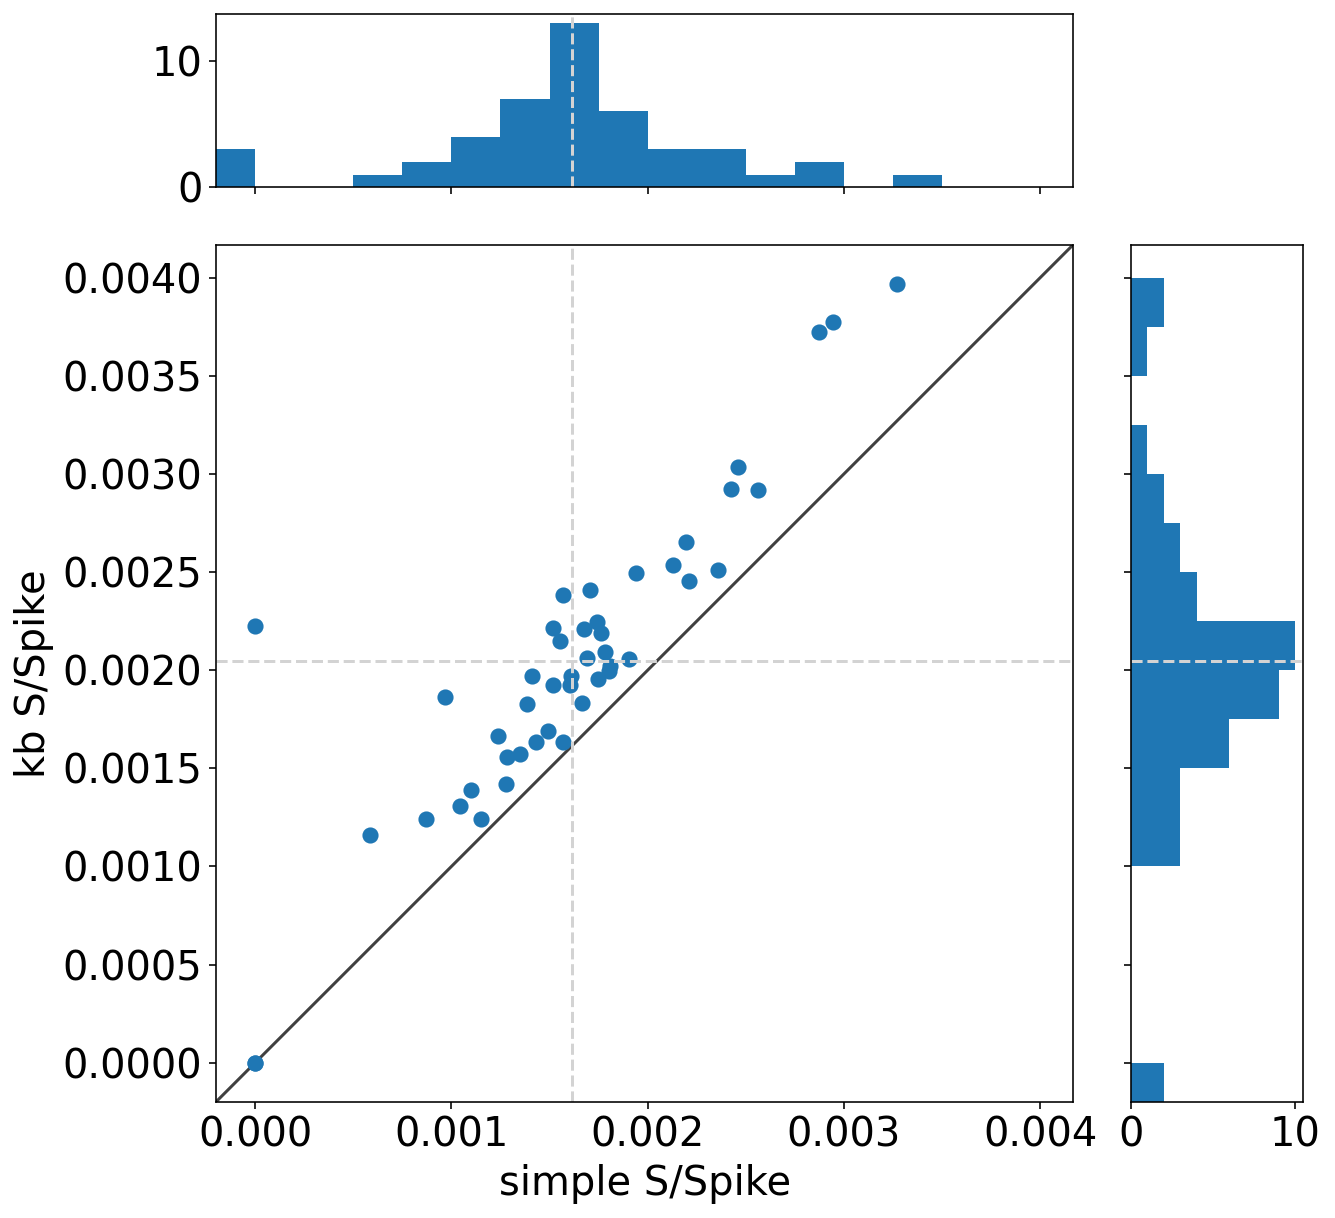

In [155]:
fig, ax = plt.subplots(figsize=(10, 10))

sm_vals = nd(sm_ntc.X[:,1:][:,0]/sm_ntc.X[:,1:][:,1])
kb_vals = nd(kb_ntc.X[:,1:][:,0]/kb_ntc.X[:,1:][:,1])

x = sm_vals[~np.isnan(sm_vals)]
y = kb_vals[~np.isnan(kb_vals)]

ax.scatter(x, y, s=50)


kwd = {
    "xlabel": "simple S/Spike",
    "ylabel":"kb S/Spike",
}

ax.set(**kwd)
yex(ax)

# create new axes on the right and on the top of the current axes
# The first argument of the new_vertical(new_horizontal) method is
# the height (width) of the axes to be created in inches.
divider = make_axes_locatable(ax)
axHistx = divider.append_axes("top", 1.2, pad=0.4, sharex=ax)
axHisty = divider.append_axes("right", 1.2, pad=0.4, sharey=ax)

# make some labels invisible
axHistx.xaxis.set_tick_params(labelbottom=False)
axHisty.yaxis.set_tick_params(labelleft=False)

# now determine nice limits by hand:
binwidth = 0.00025
xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
lim = (int(xymax/binwidth) + 1)*binwidth

bins = np.arange(-lim, lim + binwidth, binwidth)
axHistx.hist(x, bins=bins)
axHisty.hist(y, bins=bins, orientation='horizontal')

axHistx.axvline(x = x.mean(), color="lightgray", linestyle="--")
axHisty.axhline(y = y.mean(), color="lightgray", linestyle="--")

# the xaxis of axHistx and yaxis of axHisty are shared with ax,
# thus there is no need to manually adjust the xlim and ylim of these
# axis.

ax.axvline(x=x.mean(), color="lightgray", linestyle="--")
ax.axhline(y=y.mean(), color="lightgray", linestyle="--")


fig.show()

In [156]:
print(x.mean(), y.mean())
print(x.var(), y.var())


0.001612671947501427 0.0020445709
4.6824134384764045e-07 5.802702e-07


In [157]:
print(f"{kb.X.sum():,.0f}")
print(f"{sm.X.sum():,.0f}")

10,007,329
9,727,490
